In [1]:
import torch as t 
import torchvision
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pylab as plt
from torch.nn.utils import clip_grad_value_
%matplotlib inline
import pickle
from torchvision import datasets, transforms
import tqdm
import os
import sys
sys.path.append('../src/')

In [2]:
import importlib 
import var_net
import base_net 
import mnist_utils as utils
importlib.reload(utils)
importlib.reload(base_net)
importlib.reload(var_net)



<module 'var_net' from '/home/leginpc/reps/VarHyperNet/code/wine/../src/var_net.py'>

In [3]:
device = 'cuda' # cuda or cpu
device = t.device(device)
if device == 'cuda':
    t.backends.cudnn.deterministic = True
    t.backends.cudnn.benchmark = False

In [4]:
init_log_sigma = -3.0 # логарифм дисперсии вариационного распределения при инициализации
prior_sigma = 1.0 # априорная дисперсия
epoch_num = 200 #количество эпох
lamb = [10**2, 10**3, 10**4, 10**5, 10**6]
lamb = [t.tensor(l) for l in lamb]
hidden_num = 50 # количество нейронов на скрытом слое
acc_delete = [] 
start_num = 5
path_to_save = 'saved_wine'
lambda_sample_num = 5
lambda_encode = lambda x: (t.log(x) - np.log(100.0))/(np.log(10**6) - np.log(100.0))
if not os.path.exists(path_to_save):
    os.mkdir(path_to_save)
lambda_encode(lamb[0]), lambda_encode(lamb[-1])

(tensor(0.), tensor(1.))

In [5]:
from sklearn.datasets import load_wine
from torch.utils.data import TensorDataset, DataLoader
wine_X , wine_Y = load_wine(return_X_y=True)

rs = np.random.RandomState(42)
ids = list(range(len(wine_X)))
rs.shuffle(ids)

train_X, test_X = wine_X[ids[:len(ids)*4//5]], wine_X[ids[len(ids)*4//5:]]
train_Y, test_Y = wine_Y[ids[:len(ids)*4//5]], wine_Y[ids[len(ids)*4//5:]]

mean = np.mean(train_X, 0)
std = np.std(train_X, 0)

train_X = (train_X - mean)/std
test_X = (test_X - mean)/std




train_X = t.tensor(train_X).to(device)
test_X = t.tensor(test_X).to(device)
train_Y = t.tensor(train_Y).to(device)
test_Y = t.tensor(test_Y).to(device)


train_data = TensorDataset(train_X.float(),train_Y)
train_loader = DataLoader(train_data) 

test_data = TensorDataset(test_X.float(),test_Y)
test_loader = DataLoader(test_data) 

        

In [6]:
t.manual_seed(0)

for start in range(start_num):                    
        net = var_net.VarNet(base_net.BaseLayerLinear(13, 3, act=lambda x:x, prior_sigma=prior_sigma))

        net = net.to(device)
        optim = t.optim.Adam(net.parameters(), lr=5e-4)
        loss_fn = nn.CrossEntropyLoss().to(device)            
        for e in range(epoch_num):
            label = 'epoch {}: '.format(e)                
            utils.train_batches_hypernet(train_loader,  len(train_data), lambda_sample_num,
                  lambda_encode, net, device, loss_fn, optim, label, rep=False,  p_gen=lambda p_:p_*4+2)
            if e%5 == 0:
                print (utils.test_acc_hyper(net, device, test_loader, lambda_encode, lamb))
        t.save(net.state_dict(), os.path.join(path_to_save, 'base_linear_start_{}.cpk'.format(start)))

/home/leginpc/reps/VarHyperNet/code/wine/../src/linear_var_hypernet.py:162: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  t.nn.init.xavier_uniform(self.const,  init_const)
/home/leginpc/reps/VarHyperNet/code/wine/../src/linear_var_hypernet.py:164: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  t.nn.init.xavier_uniform(self.const2,  init_const2)
epoch 0: [1276.6171 1958.9396]: 100%|██████████| 142/142 [00:01<00:00, 138.04it/s] 


{tensor(100): 0.6944444444444444, tensor(1000): 0.6666666666666666, tensor(10000): 0.4444444444444444, tensor(100000): 0.19444444444444445, tensor(1000000): 0.08333333333333333}


epoch 5: [134.49843 193.51796]: 100%|██████████| 142/142 [00:00<00:00, 152.24it/s]


{tensor(100): 0.4444444444444444, tensor(1000): 0.4444444444444444, tensor(10000): 0.4722222222222222, tensor(100000): 0.5833333333333334, tensor(1000000): 0.05555555555555555}


epoch 10: [42.898808 62.831112]: 100%|██████████| 142/142 [00:00<00:00, 156.02it/s]


{tensor(100): 0.5277777777777778, tensor(1000): 0.5277777777777778, tensor(10000): 0.5, tensor(100000): 0.4722222222222222, tensor(1000000): 0.05555555555555555}


epoch 15: [20.172333 28.85083 ]: 100%|██████████| 142/142 [00:00<00:00, 167.35it/s]


{tensor(100): 0.5555555555555556, tensor(1000): 0.5555555555555556, tensor(10000): 0.5555555555555556, tensor(100000): 0.5555555555555556, tensor(1000000): 0.1388888888888889}


epoch 20: [ 7.694686 11.787017]: 100%|██████████| 142/142 [00:01<00:00, 129.80it/s]  


{tensor(100): 0.5, tensor(1000): 0.5, tensor(10000): 0.5, tensor(100000): 0.5, tensor(1000000): 0.19444444444444445}


epoch 25: [4.2607565 6.012405 ]: 100%|██████████| 142/142 [00:00<00:00, 156.88it/s]


{tensor(100): 0.3611111111111111, tensor(1000): 0.3611111111111111, tensor(10000): 0.3611111111111111, tensor(100000): 0.3611111111111111, tensor(1000000): 0.19444444444444445}


epoch 30: [2.3611526 3.213001 ]: 100%|██████████| 142/142 [00:00<00:00, 154.85it/s]


{tensor(100): 0.3888888888888889, tensor(1000): 0.3888888888888889, tensor(10000): 0.3888888888888889, tensor(100000): 0.3888888888888889, tensor(1000000): 0.2222222222222222}


epoch 35: [1.313769 1.61806 ]: 100%|██████████| 142/142 [00:00<00:00, 165.26it/s]  


{tensor(100): 0.3888888888888889, tensor(1000): 0.3888888888888889, tensor(10000): 0.3888888888888889, tensor(100000): 0.3888888888888889, tensor(1000000): 0.0}


epoch 40: [0.72292256 0.75922036]: 100%|██████████| 142/142 [00:00<00:00, 153.24it/s]


{tensor(100): 0.5833333333333334, tensor(1000): 0.5833333333333334, tensor(10000): 0.6666666666666666, tensor(100000): 0.8333333333333334, tensor(1000000): 0.0}


epoch 45: [0.6552345 0.6576531]: 100%|██████████| 142/142 [00:00<00:00, 160.41it/s]  


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.9444444444444444, tensor(100000): 0.9166666666666666, tensor(1000000): 0.0}


epoch 50: [0.65370226 0.6561274 ]: 100%|██████████| 142/142 [00:00<00:00, 153.23it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.9444444444444444, tensor(100000): 0.8611111111111112, tensor(1000000): 0.0}


epoch 55: [0.6545855  0.65689236]: 100%|██████████| 142/142 [00:00<00:00, 167.68it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.9444444444444444, tensor(100000): 0.9166666666666666, tensor(1000000): 0.0}


epoch 60: [0.65483147 0.6576934 ]: 100%|██████████| 142/142 [00:00<00:00, 160.47it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.9444444444444444, tensor(100000): 0.9166666666666666, tensor(1000000): 0.0}


epoch 65: [0.65401536 0.65670156]: 100%|██████████| 142/142 [00:00<00:00, 161.42it/s]


{tensor(100): 0.8888888888888888, tensor(1000): 0.8888888888888888, tensor(10000): 0.8888888888888888, tensor(100000): 0.8333333333333334, tensor(1000000): 0.0}


epoch 70: [0.6549531 0.6575341]: 100%|██████████| 142/142 [00:00<00:00, 166.88it/s]  


{tensor(100): 0.9166666666666666, tensor(1000): 0.9166666666666666, tensor(10000): 0.9166666666666666, tensor(100000): 0.8888888888888888, tensor(1000000): 0.0}


epoch 75: [0.6554447 0.658205 ]: 100%|██████████| 142/142 [00:00<00:00, 168.43it/s]  


{tensor(100): 0.9166666666666666, tensor(1000): 0.9166666666666666, tensor(10000): 0.9166666666666666, tensor(100000): 0.8055555555555556, tensor(1000000): 0.0}


epoch 80: [0.6526988  0.65502405]: 100%|██████████| 142/142 [00:00<00:00, 173.94it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.9444444444444444, tensor(100000): 0.8888888888888888, tensor(1000000): 0.0}


epoch 85: [0.6553129 0.6584732]: 100%|██████████| 142/142 [00:00<00:00, 145.25it/s]  


{tensor(100): 0.9166666666666666, tensor(1000): 0.9166666666666666, tensor(10000): 0.9166666666666666, tensor(100000): 0.8611111111111112, tensor(1000000): 0.0}


epoch 90: [0.6531382  0.65580726]: 100%|██████████| 142/142 [00:00<00:00, 153.15it/s]


{tensor(100): 0.9166666666666666, tensor(1000): 0.8888888888888888, tensor(10000): 0.8888888888888888, tensor(100000): 0.8055555555555556, tensor(1000000): 0.0}


epoch 95: [0.6543515 0.6568864]: 100%|██████████| 142/142 [00:00<00:00, 162.84it/s]  


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.9444444444444444, tensor(100000): 0.9166666666666666, tensor(1000000): 0.0}


epoch 100: [0.6542597 0.6565771]: 100%|██████████| 142/142 [00:00<00:00, 160.96it/s]  


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.9444444444444444, tensor(100000): 0.8611111111111112, tensor(1000000): 0.0}


epoch 105: [0.6540318  0.65680665]: 100%|██████████| 142/142 [00:00<00:00, 160.60it/s]


{tensor(100): 0.9166666666666666, tensor(1000): 0.9166666666666666, tensor(10000): 0.9444444444444444, tensor(100000): 0.8611111111111112, tensor(1000000): 0.0}


epoch 110: [0.6551026  0.65780556]: 100%|██████████| 142/142 [00:00<00:00, 159.13it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.9444444444444444, tensor(100000): 0.8055555555555556, tensor(1000000): 0.0}


epoch 115: [0.6544755  0.65703887]: 100%|██████████| 142/142 [00:00<00:00, 151.79it/s]


{tensor(100): 0.9722222222222222, tensor(1000): 0.9444444444444444, tensor(10000): 0.9444444444444444, tensor(100000): 0.9444444444444444, tensor(1000000): 0.0}


epoch 120: [0.65438056 0.6566126 ]: 100%|██████████| 142/142 [00:00<00:00, 156.25it/s]


{tensor(100): 0.9166666666666666, tensor(1000): 0.9166666666666666, tensor(10000): 0.9166666666666666, tensor(100000): 0.8611111111111112, tensor(1000000): 0.0}


epoch 125: [0.65396035 0.6564316 ]: 100%|██████████| 142/142 [00:00<00:00, 158.94it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.9444444444444444, tensor(100000): 0.9166666666666666, tensor(1000000): 0.0}


epoch 130: [0.6548959  0.65723956]: 100%|██████████| 142/142 [00:00<00:00, 155.45it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.9444444444444444, tensor(100000): 0.9444444444444444, tensor(1000000): 0.0}


epoch 135: [0.65400225 0.6571009 ]: 100%|██████████| 142/142 [00:00<00:00, 163.22it/s]


{tensor(100): 0.8888888888888888, tensor(1000): 0.8888888888888888, tensor(10000): 0.8888888888888888, tensor(100000): 0.9166666666666666, tensor(1000000): 0.0}


epoch 140: [0.6539141  0.65634567]: 100%|██████████| 142/142 [00:00<00:00, 157.54it/s]


{tensor(100): 0.9166666666666666, tensor(1000): 0.8888888888888888, tensor(10000): 0.8888888888888888, tensor(100000): 0.8611111111111112, tensor(1000000): 0.0}


epoch 145: [0.65439874 0.6570295 ]: 100%|██████████| 142/142 [00:00<00:00, 163.08it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.9444444444444444, tensor(100000): 0.9166666666666666, tensor(1000000): 0.0}


epoch 150: [0.65415883 0.6566715 ]: 100%|██████████| 142/142 [00:00<00:00, 162.17it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.9444444444444444, tensor(100000): 0.9444444444444444, tensor(1000000): 0.0}


epoch 155: [0.6537404 0.6561832]: 100%|██████████| 142/142 [00:00<00:00, 162.64it/s]  


{tensor(100): 0.8888888888888888, tensor(1000): 0.8888888888888888, tensor(10000): 0.8888888888888888, tensor(100000): 0.8611111111111112, tensor(1000000): 0.0}


epoch 160: [0.6542188  0.65661895]: 100%|██████████| 142/142 [00:00<00:00, 158.36it/s]


{tensor(100): 0.9722222222222222, tensor(1000): 0.9722222222222222, tensor(10000): 0.9722222222222222, tensor(100000): 0.9166666666666666, tensor(1000000): 0.027777777777777776}


epoch 165: [0.6538172 0.6561477]: 100%|██████████| 142/142 [00:00<00:00, 162.58it/s]  


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.9166666666666666, tensor(100000): 0.8333333333333334, tensor(1000000): 0.0}


epoch 170: [0.6529654  0.65531546]: 100%|██████████| 142/142 [00:00<00:00, 162.14it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.9444444444444444, tensor(100000): 0.8611111111111112, tensor(1000000): 0.0}


epoch 175: [0.65458924 0.65694255]: 100%|██████████| 142/142 [00:00<00:00, 164.29it/s]


{tensor(100): 0.9166666666666666, tensor(1000): 0.9166666666666666, tensor(10000): 0.9166666666666666, tensor(100000): 0.8333333333333334, tensor(1000000): 0.0}


epoch 180: [0.65468 0.65748]: 100%|██████████| 142/142 [00:00<00:00, 163.92it/s]      


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.9444444444444444, tensor(100000): 0.9444444444444444, tensor(1000000): 0.0}


epoch 185: [0.6536496  0.65611637]: 100%|██████████| 142/142 [00:00<00:00, 148.37it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.9444444444444444, tensor(100000): 0.9444444444444444, tensor(1000000): 0.0}


epoch 190: [0.6538886 0.6563575]: 100%|██████████| 142/142 [00:00<00:00, 156.48it/s]  


{tensor(100): 0.9722222222222222, tensor(1000): 0.9722222222222222, tensor(10000): 0.9722222222222222, tensor(100000): 0.9166666666666666, tensor(1000000): 0.0}


epoch 195: [0.6540311  0.65641886]: 100%|██████████| 142/142 [00:00<00:00, 158.73it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.9444444444444444, tensor(100000): 0.9166666666666666, tensor(1000000): 0.0}


epoch 0: [1932.7898 2760.1272]: 100%|██████████| 142/142 [00:00<00:00, 162.94it/s]


{tensor(100): 0.6388888888888888, tensor(1000): 0.5, tensor(10000): 0.4722222222222222, tensor(100000): 0.3055555555555556, tensor(1000000): 0.1388888888888889}


epoch 5: [176.96133 259.81332]: 100%|██████████| 142/142 [00:00<00:00, 164.28it/s]


{tensor(100): 0.6666666666666666, tensor(1000): 0.6666666666666666, tensor(10000): 0.6666666666666666, tensor(100000): 0.6388888888888888, tensor(1000000): 0.16666666666666666}


epoch 10: [32.234158 45.27449 ]: 100%|██████████| 142/142 [00:00<00:00, 162.21it/s]


{tensor(100): 0.6666666666666666, tensor(1000): 0.6666666666666666, tensor(10000): 0.6944444444444444, tensor(100000): 0.6944444444444444, tensor(1000000): 0.1111111111111111}


epoch 15: [ 9.78796  14.328846]: 100%|██████████| 142/142 [00:00<00:00, 156.01it/s]  


{tensor(100): 0.6666666666666666, tensor(1000): 0.6666666666666666, tensor(10000): 0.6666666666666666, tensor(100000): 0.6666666666666666, tensor(1000000): 0.05555555555555555}


epoch 20: [4.277264 6.055838]: 100%|██████████| 142/142 [00:00<00:00, 153.63it/s]  


{tensor(100): 0.6666666666666666, tensor(1000): 0.6666666666666666, tensor(10000): 0.6666666666666666, tensor(100000): 0.6944444444444444, tensor(1000000): 0.05555555555555555}


epoch 25: [1.3391585 1.6877322]: 100%|██████████| 142/142 [00:00<00:00, 160.93it/s]


{tensor(100): 0.6944444444444444, tensor(1000): 0.6944444444444444, tensor(10000): 0.6944444444444444, tensor(100000): 0.75, tensor(1000000): 0.08333333333333333}


epoch 30: [0.683553  0.7019767]: 100%|██████████| 142/142 [00:00<00:00, 161.29it/s]  


{tensor(100): 0.8611111111111112, tensor(1000): 0.8611111111111112, tensor(10000): 0.8611111111111112, tensor(100000): 0.8333333333333334, tensor(1000000): 0.0}


epoch 35: [0.654284  0.6564579]: 100%|██████████| 142/142 [00:00<00:00, 159.26it/s]  


{tensor(100): 0.9166666666666666, tensor(1000): 0.9166666666666666, tensor(10000): 0.9166666666666666, tensor(100000): 0.8888888888888888, tensor(1000000): 0.0}


epoch 40: [0.65456593 0.65700376]: 100%|██████████| 142/142 [00:00<00:00, 161.64it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.9444444444444444, tensor(100000): 0.9166666666666666, tensor(1000000): 0.08333333333333333}


epoch 45: [0.6545646  0.65686524]: 100%|██████████| 142/142 [00:00<00:00, 160.30it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.9444444444444444, tensor(100000): 0.9444444444444444, tensor(1000000): 0.0}


epoch 50: [0.6542317 0.6571482]: 100%|██████████| 142/142 [00:00<00:00, 147.66it/s]  


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.9444444444444444, tensor(100000): 0.9166666666666666, tensor(1000000): 0.0}


epoch 55: [0.6536921  0.65633863]: 100%|██████████| 142/142 [00:00<00:00, 157.12it/s]


{tensor(100): 0.8888888888888888, tensor(1000): 0.8888888888888888, tensor(10000): 0.8888888888888888, tensor(100000): 0.8888888888888888, tensor(1000000): 0.0}


epoch 60: [0.65419817 0.6569071 ]: 100%|██████████| 142/142 [00:00<00:00, 157.57it/s]


{tensor(100): 0.9166666666666666, tensor(1000): 0.8888888888888888, tensor(10000): 0.8888888888888888, tensor(100000): 0.8611111111111112, tensor(1000000): 0.0}


epoch 65: [0.6533815 0.6562889]: 100%|██████████| 142/142 [00:00<00:00, 154.10it/s]  


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.9166666666666666, tensor(100000): 0.8888888888888888, tensor(1000000): 0.0}


epoch 70: [0.6537439 0.6565504]: 100%|██████████| 142/142 [00:00<00:00, 158.06it/s]  


{tensor(100): 0.9166666666666666, tensor(1000): 0.9166666666666666, tensor(10000): 0.8888888888888888, tensor(100000): 0.8333333333333334, tensor(1000000): 0.0}


epoch 75: [0.6539756 0.6570431]: 100%|██████████| 142/142 [00:00<00:00, 157.76it/s]  


{tensor(100): 0.9722222222222222, tensor(1000): 0.9722222222222222, tensor(10000): 0.8888888888888888, tensor(100000): 0.8611111111111112, tensor(1000000): 0.1111111111111111}


epoch 80: [0.6545445  0.65760314]: 100%|██████████| 142/142 [00:00<00:00, 151.91it/s]


{tensor(100): 0.9166666666666666, tensor(1000): 0.9166666666666666, tensor(10000): 0.9166666666666666, tensor(100000): 0.8888888888888888, tensor(1000000): 0.0}


epoch 85: [0.6533481 0.6564711]: 100%|██████████| 142/142 [00:00<00:00, 156.64it/s]  


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.9444444444444444, tensor(100000): 0.9444444444444444, tensor(1000000): 0.16666666666666666}


epoch 90: [0.6528207  0.65534395]: 100%|██████████| 142/142 [00:00<00:00, 155.43it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.9444444444444444, tensor(100000): 0.9444444444444444, tensor(1000000): 0.0}


epoch 95: [0.6544414 0.6573553]: 100%|██████████| 142/142 [00:00<00:00, 160.41it/s]  


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.9166666666666666, tensor(100000): 0.8888888888888888, tensor(1000000): 0.0}


epoch 100: [0.65466183 0.6573928 ]: 100%|██████████| 142/142 [00:00<00:00, 158.61it/s]


{tensor(100): 0.9166666666666666, tensor(1000): 0.9166666666666666, tensor(10000): 0.9166666666666666, tensor(100000): 0.9166666666666666, tensor(1000000): 0.0}


epoch 105: [0.65372264 0.6568827 ]: 100%|██████████| 142/142 [00:00<00:00, 157.48it/s]


{tensor(100): 0.9722222222222222, tensor(1000): 0.9722222222222222, tensor(10000): 0.9444444444444444, tensor(100000): 0.8888888888888888, tensor(1000000): 0.0}


epoch 110: [0.65435994 0.6566419 ]: 100%|██████████| 142/142 [00:00<00:00, 158.27it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.9444444444444444, tensor(100000): 0.9444444444444444, tensor(1000000): 0.0}


epoch 115: [0.65456855 0.65735286]: 100%|██████████| 142/142 [00:00<00:00, 155.22it/s]


{tensor(100): 0.8888888888888888, tensor(1000): 0.8888888888888888, tensor(10000): 0.8888888888888888, tensor(100000): 0.8333333333333334, tensor(1000000): 0.0}


epoch 120: [0.654073   0.65635055]: 100%|██████████| 142/142 [00:00<00:00, 157.19it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.9166666666666666, tensor(100000): 0.8611111111111112, tensor(1000000): 0.0}


epoch 125: [0.6540492 0.6564234]: 100%|██████████| 142/142 [00:00<00:00, 160.29it/s]  


{tensor(100): 0.9444444444444444, tensor(1000): 0.9166666666666666, tensor(10000): 0.8888888888888888, tensor(100000): 0.8055555555555556, tensor(1000000): 0.0}


epoch 130: [0.6539932 0.6564629]: 100%|██████████| 142/142 [00:00<00:00, 160.34it/s]  


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.9444444444444444, tensor(100000): 0.8888888888888888, tensor(1000000): 0.0}


epoch 135: [0.6546186 0.6572486]: 100%|██████████| 142/142 [00:00<00:00, 150.37it/s]  


{tensor(100): 0.9722222222222222, tensor(1000): 0.9444444444444444, tensor(10000): 0.9444444444444444, tensor(100000): 0.9444444444444444, tensor(1000000): 0.0}


epoch 140: [0.6539123  0.65656525]: 100%|██████████| 142/142 [00:00<00:00, 164.63it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.9444444444444444, tensor(100000): 0.9444444444444444, tensor(1000000): 0.08333333333333333}


epoch 145: [0.6533702  0.65602547]: 100%|██████████| 142/142 [00:00<00:00, 165.05it/s]


{tensor(100): 0.8888888888888888, tensor(1000): 0.8888888888888888, tensor(10000): 0.8888888888888888, tensor(100000): 0.8611111111111112, tensor(1000000): 0.0}


epoch 150: [0.65452135 0.65766805]: 100%|██████████| 142/142 [00:00<00:00, 162.36it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.9444444444444444, tensor(100000): 0.9166666666666666, tensor(1000000): 0.0}


epoch 155: [0.65499854 0.657845  ]: 100%|██████████| 142/142 [00:00<00:00, 154.64it/s]


{tensor(100): 0.9722222222222222, tensor(1000): 0.9444444444444444, tensor(10000): 0.9444444444444444, tensor(100000): 0.9166666666666666, tensor(1000000): 0.0}


epoch 160: [0.6545702 0.6579963]: 100%|██████████| 142/142 [00:00<00:00, 159.24it/s]  


{tensor(100): 0.9444444444444444, tensor(1000): 0.9166666666666666, tensor(10000): 0.9166666666666666, tensor(100000): 0.8611111111111112, tensor(1000000): 0.0}


epoch 165: [0.65359336 0.65663093]: 100%|██████████| 142/142 [00:00<00:00, 163.08it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.9444444444444444, tensor(100000): 0.8888888888888888, tensor(1000000): 0.0}


epoch 170: [0.6552737  0.65783066]: 100%|██████████| 142/142 [00:00<00:00, 166.78it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.9444444444444444, tensor(100000): 0.9444444444444444, tensor(1000000): 0.0}


epoch 175: [0.6548304  0.65728986]: 100%|██████████| 142/142 [00:00<00:00, 160.81it/s]


{tensor(100): 0.9166666666666666, tensor(1000): 0.9166666666666666, tensor(10000): 0.9166666666666666, tensor(100000): 0.8888888888888888, tensor(1000000): 0.0}


epoch 180: [0.6546693  0.65703166]: 100%|██████████| 142/142 [00:00<00:00, 163.20it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.9444444444444444, tensor(100000): 0.9444444444444444, tensor(1000000): 0.0}


epoch 185: [0.65348387 0.65604603]: 100%|██████████| 142/142 [00:00<00:00, 164.98it/s]


{tensor(100): 0.8888888888888888, tensor(1000): 0.8888888888888888, tensor(10000): 0.8888888888888888, tensor(100000): 0.8888888888888888, tensor(1000000): 0.0}


epoch 190: [0.65524095 0.65792924]: 100%|██████████| 142/142 [00:00<00:00, 163.78it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.9444444444444444, tensor(100000): 0.8888888888888888, tensor(1000000): 0.0}


epoch 195: [0.6535594 0.6561783]: 100%|██████████| 142/142 [00:00<00:00, 162.20it/s]  


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.9444444444444444, tensor(100000): 0.8055555555555556, tensor(1000000): 0.0}


epoch 0: [1376.5005 2065.4297]: 100%|██████████| 142/142 [00:00<00:00, 164.24it/s]


{tensor(100): 0.0, tensor(1000): 0.05555555555555555, tensor(10000): 0.19444444444444445, tensor(100000): 0.3611111111111111, tensor(1000000): 0.5555555555555556}


epoch 5: [275.34158 415.91232]: 100%|██████████| 142/142 [00:00<00:00, 163.88it/s]


{tensor(100): 0.19444444444444445, tensor(1000): 0.08333333333333333, tensor(10000): 0.027777777777777776, tensor(100000): 0.08333333333333333, tensor(1000000): 0.5833333333333334}


epoch 10: [111.59527 164.09969]: 100%|██████████| 142/142 [00:00<00:00, 156.40it/s]  


{tensor(100): 0.3611111111111111, tensor(1000): 0.3611111111111111, tensor(10000): 0.3611111111111111, tensor(100000): 0.2222222222222222, tensor(1000000): 0.4722222222222222}


epoch 15: [60.872738 95.25405 ]: 100%|██████████| 142/142 [00:00<00:00, 154.54it/s]


{tensor(100): 0.3333333333333333, tensor(1000): 0.3333333333333333, tensor(10000): 0.3611111111111111, tensor(100000): 0.3611111111111111, tensor(1000000): 0.3888888888888889}


epoch 20: [29.780972 44.420742]: 100%|██████████| 142/142 [00:00<00:00, 162.35it/s]


{tensor(100): 0.3055555555555556, tensor(1000): 0.3055555555555556, tensor(10000): 0.3055555555555556, tensor(100000): 0.3333333333333333, tensor(1000000): 0.4166666666666667}


epoch 25: [19.511381 28.929632]: 100%|██████████| 142/142 [00:00<00:00, 162.73it/s]


{tensor(100): 0.3055555555555556, tensor(1000): 0.3055555555555556, tensor(10000): 0.3055555555555556, tensor(100000): 0.3055555555555556, tensor(1000000): 0.3611111111111111}


epoch 30: [16.64802  24.133974]: 100%|██████████| 142/142 [00:00<00:00, 157.28it/s] 


{tensor(100): 0.3055555555555556, tensor(1000): 0.3055555555555556, tensor(10000): 0.3055555555555556, tensor(100000): 0.3055555555555556, tensor(1000000): 0.3888888888888889}


epoch 35: [ 9.956188 14.548063]: 100%|██████████| 142/142 [00:00<00:00, 160.63it/s]  


{tensor(100): 0.3055555555555556, tensor(1000): 0.3055555555555556, tensor(10000): 0.3055555555555556, tensor(100000): 0.3055555555555556, tensor(1000000): 0.3888888888888889}


epoch 40: [ 8.761931 12.557022]: 100%|██████████| 142/142 [00:00<00:00, 156.67it/s]  


{tensor(100): 0.3055555555555556, tensor(1000): 0.3055555555555556, tensor(10000): 0.3055555555555556, tensor(100000): 0.3055555555555556, tensor(1000000): 0.3888888888888889}


epoch 45: [4.9788265 6.946334 ]: 100%|██████████| 142/142 [00:00<00:00, 160.61it/s]


{tensor(100): 0.3055555555555556, tensor(1000): 0.3055555555555556, tensor(10000): 0.3055555555555556, tensor(100000): 0.3055555555555556, tensor(1000000): 0.0}


epoch 50: [3.0177443 4.2321663]: 100%|██████████| 142/142 [00:00<00:00, 161.88it/s]


{tensor(100): 0.3055555555555556, tensor(1000): 0.3055555555555556, tensor(10000): 0.3055555555555556, tensor(100000): 0.3055555555555556, tensor(1000000): 0.0}


epoch 55: [1.8123846 2.3987484]: 100%|██████████| 142/142 [00:00<00:00, 157.35it/s]


{tensor(100): 0.3055555555555556, tensor(1000): 0.3055555555555556, tensor(10000): 0.3055555555555556, tensor(100000): 0.3055555555555556, tensor(1000000): 0.0}


epoch 60: [1.1147355 1.3407013]: 100%|██████████| 142/142 [00:00<00:00, 162.60it/s]


{tensor(100): 0.3055555555555556, tensor(1000): 0.3055555555555556, tensor(10000): 0.3055555555555556, tensor(100000): 0.3055555555555556, tensor(1000000): 0.0}


epoch 65: [0.677529   0.69068664]: 100%|██████████| 142/142 [00:00<00:00, 159.45it/s]


{tensor(100): 0.8333333333333334, tensor(1000): 0.8333333333333334, tensor(10000): 0.8611111111111112, tensor(100000): 0.8611111111111112, tensor(1000000): 0.0}


epoch 70: [0.6544117 0.6570574]: 100%|██████████| 142/142 [00:00<00:00, 154.43it/s]  


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.9444444444444444, tensor(100000): 0.9166666666666666, tensor(1000000): 0.0}


epoch 75: [0.6532958  0.65584844]: 100%|██████████| 142/142 [00:00<00:00, 165.20it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.9444444444444444, tensor(100000): 0.9444444444444444, tensor(1000000): 0.0}


epoch 80: [0.6542695 0.6565905]: 100%|██████████| 142/142 [00:00<00:00, 161.27it/s]  


{tensor(100): 0.9166666666666666, tensor(1000): 0.9166666666666666, tensor(10000): 0.8888888888888888, tensor(100000): 0.8611111111111112, tensor(1000000): 0.0}


epoch 85: [0.6544036 0.6568529]: 100%|██████████| 142/142 [00:00<00:00, 161.90it/s]  


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.9166666666666666, tensor(100000): 0.8888888888888888, tensor(1000000): 0.0}


epoch 90: [0.6542937 0.6572989]: 100%|██████████| 142/142 [00:00<00:00, 165.16it/s]  


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.9444444444444444, tensor(100000): 0.9166666666666666, tensor(1000000): 0.0}


epoch 95: [0.6544822 0.6569998]: 100%|██████████| 142/142 [00:00<00:00, 146.43it/s]  


{tensor(100): 0.9166666666666666, tensor(1000): 0.9166666666666666, tensor(10000): 0.8888888888888888, tensor(100000): 0.8888888888888888, tensor(1000000): 0.0}


epoch 100: [0.65369   0.6565768]: 100%|██████████| 142/142 [00:00<00:00, 162.98it/s]  


{tensor(100): 0.9722222222222222, tensor(1000): 0.9444444444444444, tensor(10000): 0.9444444444444444, tensor(100000): 0.8888888888888888, tensor(1000000): 0.0}


epoch 105: [0.65426534 0.6566734 ]: 100%|██████████| 142/142 [00:00<00:00, 155.04it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.9444444444444444, tensor(100000): 0.8888888888888888, tensor(1000000): 0.0}


epoch 110: [0.6538035 0.6565792]: 100%|██████████| 142/142 [00:00<00:00, 170.31it/s]  


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.9444444444444444, tensor(100000): 0.9444444444444444, tensor(1000000): 0.0}


epoch 115: [0.65486723 0.6578297 ]: 100%|██████████| 142/142 [00:00<00:00, 150.17it/s]


{tensor(100): 0.9166666666666666, tensor(1000): 0.9166666666666666, tensor(10000): 0.9166666666666666, tensor(100000): 0.8333333333333334, tensor(1000000): 0.0}


epoch 120: [0.65380746 0.6562828 ]: 100%|██████████| 142/142 [00:00<00:00, 167.21it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.9166666666666666, tensor(100000): 0.8055555555555556, tensor(1000000): 0.0}


epoch 125: [0.6538005  0.65627235]: 100%|██████████| 142/142 [00:00<00:00, 158.04it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.9444444444444444, tensor(100000): 0.9166666666666666, tensor(1000000): 0.0}


epoch 130: [0.6535286 0.655988 ]: 100%|██████████| 142/142 [00:00<00:00, 165.07it/s]  


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.9444444444444444, tensor(100000): 0.8888888888888888, tensor(1000000): 0.0}


epoch 135: [0.6535587 0.6561643]: 100%|██████████| 142/142 [00:00<00:00, 150.33it/s]  


{tensor(100): 0.9166666666666666, tensor(1000): 0.9166666666666666, tensor(10000): 0.9166666666666666, tensor(100000): 0.8888888888888888, tensor(1000000): 0.0}


epoch 140: [0.6548213 0.657218 ]: 100%|██████████| 142/142 [00:00<00:00, 163.49it/s]  


{tensor(100): 0.9166666666666666, tensor(1000): 0.9166666666666666, tensor(10000): 0.9166666666666666, tensor(100000): 0.8888888888888888, tensor(1000000): 0.0}


epoch 145: [0.6544779  0.65676177]: 100%|██████████| 142/142 [00:00<00:00, 155.90it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.9444444444444444, tensor(100000): 0.9166666666666666, tensor(1000000): 0.0}


epoch 150: [0.6536331 0.656207 ]: 100%|██████████| 142/142 [00:00<00:00, 154.17it/s]  


{tensor(100): 0.8888888888888888, tensor(1000): 0.8888888888888888, tensor(10000): 0.8611111111111112, tensor(100000): 0.8055555555555556, tensor(1000000): 0.0}


epoch 155: [0.65282214 0.6554557 ]: 100%|██████████| 142/142 [00:00<00:00, 151.05it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.9444444444444444, tensor(100000): 0.8333333333333334, tensor(1000000): 0.0}


epoch 160: [0.65569526 0.65879625]: 100%|██████████| 142/142 [00:00<00:00, 146.29it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.9444444444444444, tensor(100000): 0.9166666666666666, tensor(1000000): 0.0}


epoch 165: [0.6538768 0.6567488]: 100%|██████████| 142/142 [00:01<00:00, 129.07it/s]  


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.9444444444444444, tensor(100000): 0.9166666666666666, tensor(1000000): 0.0}


epoch 170: [0.6538076  0.65612876]: 100%|██████████| 142/142 [00:01<00:00, 133.35it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.9444444444444444, tensor(100000): 0.8888888888888888, tensor(1000000): 0.0}


epoch 175: [0.65422064 0.65655404]: 100%|██████████| 142/142 [00:00<00:00, 149.52it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.9444444444444444, tensor(100000): 0.9444444444444444, tensor(1000000): 0.0}


epoch 180: [0.6542829  0.65666306]: 100%|██████████| 142/142 [00:00<00:00, 144.34it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.9444444444444444, tensor(100000): 0.9444444444444444, tensor(1000000): 0.0}


epoch 185: [0.6538235  0.65649945]: 100%|██████████| 142/142 [00:01<00:00, 131.99it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.9444444444444444, tensor(100000): 0.8888888888888888, tensor(1000000): 0.0}


epoch 190: [0.65322745 0.65621865]: 100%|██████████| 142/142 [00:00<00:00, 157.29it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.9444444444444444, tensor(100000): 0.9444444444444444, tensor(1000000): 0.0}


epoch 195: [0.6538273 0.656431 ]: 100%|██████████| 142/142 [00:00<00:00, 161.10it/s]  


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.9444444444444444, tensor(100000): 0.9166666666666666, tensor(1000000): 0.027777777777777776}


epoch 0: [1724.0715 2556.8267]: 100%|██████████| 142/142 [00:00<00:00, 155.30it/s]


{tensor(100): 0.3333333333333333, tensor(1000): 0.3055555555555556, tensor(10000): 0.3055555555555556, tensor(100000): 0.2777777777777778, tensor(1000000): 0.2777777777777778}


epoch 5: [494.88403 751.1224 ]: 100%|██████████| 142/142 [00:00<00:00, 145.63it/s]


{tensor(100): 0.2777777777777778, tensor(1000): 0.3611111111111111, tensor(10000): 0.4444444444444444, tensor(100000): 0.3055555555555556, tensor(1000000): 0.3055555555555556}


epoch 10: [162.37587 254.68303]: 100%|██████████| 142/142 [00:00<00:00, 152.71it/s]


{tensor(100): 0.3333333333333333, tensor(1000): 0.3055555555555556, tensor(10000): 0.2777777777777778, tensor(100000): 0.3055555555555556, tensor(1000000): 0.3055555555555556}


epoch 15: [60.589382 92.227585]: 100%|██████████| 142/142 [00:00<00:00, 160.56it/s] 


{tensor(100): 0.1388888888888889, tensor(1000): 0.1388888888888889, tensor(10000): 0.1388888888888889, tensor(100000): 0.4444444444444444, tensor(1000000): 0.3055555555555556}


epoch 20: [27.966963 40.827065]: 100%|██████████| 142/142 [00:00<00:00, 157.61it/s] 


{tensor(100): 0.3055555555555556, tensor(1000): 0.3055555555555556, tensor(10000): 0.3333333333333333, tensor(100000): 0.4722222222222222, tensor(1000000): 0.3055555555555556}


epoch 25: [18.00195  27.435324]: 100%|██████████| 142/142 [00:00<00:00, 144.77it/s]


{tensor(100): 0.3055555555555556, tensor(1000): 0.3055555555555556, tensor(10000): 0.3055555555555556, tensor(100000): 0.4166666666666667, tensor(1000000): 0.3055555555555556}


epoch 30: [16.384087 23.904547]: 100%|██████████| 142/142 [00:00<00:00, 159.98it/s] 


{tensor(100): 0.3055555555555556, tensor(1000): 0.3055555555555556, tensor(10000): 0.3055555555555556, tensor(100000): 0.3055555555555556, tensor(1000000): 0.3055555555555556}


epoch 35: [ 8.578788 12.829696]: 100%|██████████| 142/142 [00:00<00:00, 147.09it/s]  


{tensor(100): 0.3055555555555556, tensor(1000): 0.3055555555555556, tensor(10000): 0.3055555555555556, tensor(100000): 0.3055555555555556, tensor(1000000): 0.3055555555555556}


epoch 40: [5.398956  7.7807198]: 100%|██████████| 142/142 [00:00<00:00, 161.22it/s] 


{tensor(100): 0.3055555555555556, tensor(1000): 0.3055555555555556, tensor(10000): 0.3055555555555556, tensor(100000): 0.3055555555555556, tensor(1000000): 0.3055555555555556}


epoch 45: [4.229442 5.824743]: 100%|██████████| 142/142 [00:00<00:00, 148.45it/s]  


{tensor(100): 0.3055555555555556, tensor(1000): 0.3055555555555556, tensor(10000): 0.3055555555555556, tensor(100000): 0.3055555555555556, tensor(1000000): 0.3055555555555556}


epoch 50: [1.3551422 1.7489452]: 100%|██████████| 142/142 [00:00<00:00, 155.98it/s]


{tensor(100): 0.3055555555555556, tensor(1000): 0.3055555555555556, tensor(10000): 0.3055555555555556, tensor(100000): 0.3333333333333333, tensor(1000000): 0.3055555555555556}


epoch 55: [0.7426671 0.7880265]: 100%|██████████| 142/142 [00:00<00:00, 161.97it/s]  


{tensor(100): 0.4444444444444444, tensor(1000): 0.4444444444444444, tensor(10000): 0.5277777777777778, tensor(100000): 0.7222222222222222, tensor(1000000): 0.027777777777777776}


epoch 60: [0.65318877 0.6557336 ]: 100%|██████████| 142/142 [00:00<00:00, 161.22it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.9444444444444444, tensor(100000): 0.8333333333333334, tensor(1000000): 0.0}


epoch 65: [0.6539049  0.65679824]: 100%|██████████| 142/142 [00:00<00:00, 155.11it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.9444444444444444, tensor(100000): 0.8611111111111112, tensor(1000000): 0.0}


epoch 70: [0.65514565 0.6579395 ]: 100%|██████████| 142/142 [00:00<00:00, 156.45it/s]


{tensor(100): 0.9722222222222222, tensor(1000): 0.9722222222222222, tensor(10000): 0.9722222222222222, tensor(100000): 0.8888888888888888, tensor(1000000): 0.0}


epoch 75: [0.6553019  0.65842885]: 100%|██████████| 142/142 [00:00<00:00, 152.29it/s]


{tensor(100): 0.9166666666666666, tensor(1000): 0.9166666666666666, tensor(10000): 0.9166666666666666, tensor(100000): 0.9166666666666666, tensor(1000000): 0.0}


epoch 80: [0.6549247  0.65741944]: 100%|██████████| 142/142 [00:00<00:00, 158.63it/s]


{tensor(100): 0.9722222222222222, tensor(1000): 0.9722222222222222, tensor(10000): 0.9444444444444444, tensor(100000): 0.9166666666666666, tensor(1000000): 0.0}


epoch 85: [0.65443754 0.65732205]: 100%|██████████| 142/142 [00:00<00:00, 152.72it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.9444444444444444, tensor(100000): 0.8888888888888888, tensor(1000000): 0.0}


epoch 90: [0.6538816 0.6563709]: 100%|██████████| 142/142 [00:00<00:00, 149.73it/s]  


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.9166666666666666, tensor(100000): 0.8611111111111112, tensor(1000000): 0.0}


epoch 95: [0.65515405 0.6574362 ]: 100%|██████████| 142/142 [00:00<00:00, 160.47it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.9444444444444444, tensor(100000): 0.8333333333333334, tensor(1000000): 0.0}


epoch 100: [0.65408856 0.65669256]: 100%|██████████| 142/142 [00:00<00:00, 157.01it/s]


{tensor(100): 0.9166666666666666, tensor(1000): 0.9166666666666666, tensor(10000): 0.8888888888888888, tensor(100000): 0.8888888888888888, tensor(1000000): 0.0}


epoch 105: [0.6545317 0.6568873]: 100%|██████████| 142/142 [00:00<00:00, 147.39it/s]  


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.9444444444444444, tensor(100000): 0.9444444444444444, tensor(1000000): 0.0}


epoch 110: [0.6538018 0.6565548]: 100%|██████████| 142/142 [00:00<00:00, 156.02it/s]  


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.9444444444444444, tensor(100000): 0.9166666666666666, tensor(1000000): 0.0}


epoch 115: [0.65389884 0.65627724]: 100%|██████████| 142/142 [00:00<00:00, 156.12it/s]


{tensor(100): 0.9166666666666666, tensor(1000): 0.9166666666666666, tensor(10000): 0.9166666666666666, tensor(100000): 0.8611111111111112, tensor(1000000): 0.0}


epoch 120: [0.65357894 0.6569401 ]: 100%|██████████| 142/142 [00:00<00:00, 158.67it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.9444444444444444, tensor(100000): 0.8333333333333334, tensor(1000000): 0.0}


epoch 125: [0.6544898  0.65726304]: 100%|██████████| 142/142 [00:00<00:00, 157.77it/s]


{tensor(100): 0.9166666666666666, tensor(1000): 0.9166666666666666, tensor(10000): 0.9166666666666666, tensor(100000): 0.9166666666666666, tensor(1000000): 0.0}


epoch 130: [0.6535012  0.65655166]: 100%|██████████| 142/142 [00:00<00:00, 155.32it/s]


{tensor(100): 0.9166666666666666, tensor(1000): 0.9166666666666666, tensor(10000): 0.9166666666666666, tensor(100000): 0.8611111111111112, tensor(1000000): 0.0}


epoch 135: [0.65544647 0.65853536]: 100%|██████████| 142/142 [00:00<00:00, 159.27it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.9444444444444444, tensor(100000): 0.9444444444444444, tensor(1000000): 0.0}


epoch 140: [0.653383   0.65594804]: 100%|██████████| 142/142 [00:00<00:00, 156.54it/s]


{tensor(100): 0.9166666666666666, tensor(1000): 0.9166666666666666, tensor(10000): 0.8888888888888888, tensor(100000): 0.8611111111111112, tensor(1000000): 0.0}


epoch 145: [0.6541391  0.65643704]: 100%|██████████| 142/142 [00:00<00:00, 147.29it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.9444444444444444, tensor(100000): 0.9444444444444444, tensor(1000000): 0.0}


epoch 150: [0.6541847  0.65689754]: 100%|██████████| 142/142 [00:00<00:00, 145.52it/s]


{tensor(100): 0.9166666666666666, tensor(1000): 0.9444444444444444, tensor(10000): 0.9444444444444444, tensor(100000): 0.9444444444444444, tensor(1000000): 0.0}


epoch 155: [0.6546153  0.65737474]: 100%|██████████| 142/142 [00:00<00:00, 155.11it/s]


{tensor(100): 0.9166666666666666, tensor(1000): 0.9166666666666666, tensor(10000): 0.9166666666666666, tensor(100000): 0.9166666666666666, tensor(1000000): 0.0}


epoch 160: [0.65469396 0.65728754]: 100%|██████████| 142/142 [00:00<00:00, 160.86it/s]


{tensor(100): 0.9722222222222222, tensor(1000): 0.9722222222222222, tensor(10000): 0.9722222222222222, tensor(100000): 0.9722222222222222, tensor(1000000): 0.0}


epoch 165: [0.65514225 0.6578076 ]: 100%|██████████| 142/142 [00:00<00:00, 156.74it/s]


{tensor(100): 0.9722222222222222, tensor(1000): 0.9722222222222222, tensor(10000): 0.9722222222222222, tensor(100000): 0.9444444444444444, tensor(1000000): 0.0}


epoch 170: [0.6552803  0.65794206]: 100%|██████████| 142/142 [00:00<00:00, 154.85it/s]


{tensor(100): 0.9166666666666666, tensor(1000): 0.9166666666666666, tensor(10000): 0.9166666666666666, tensor(100000): 0.8611111111111112, tensor(1000000): 0.0}


epoch 175: [0.6533668  0.65578055]: 100%|██████████| 142/142 [00:00<00:00, 160.47it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.9444444444444444, tensor(100000): 0.9444444444444444, tensor(1000000): 0.0}


epoch 180: [0.6542246 0.6567134]: 100%|██████████| 142/142 [00:00<00:00, 158.66it/s]  


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.9444444444444444, tensor(100000): 0.9166666666666666, tensor(1000000): 0.0}


epoch 185: [0.654363  0.6575276]: 100%|██████████| 142/142 [00:00<00:00, 158.49it/s]  


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.9444444444444444, tensor(100000): 0.8611111111111112, tensor(1000000): 0.0}


epoch 190: [0.65375394 0.6560989 ]: 100%|██████████| 142/142 [00:00<00:00, 158.60it/s]


{tensor(100): 0.9166666666666666, tensor(1000): 0.8888888888888888, tensor(10000): 0.8888888888888888, tensor(100000): 0.8611111111111112, tensor(1000000): 0.0}


epoch 195: [0.6553123 0.658468 ]: 100%|██████████| 142/142 [00:00<00:00, 159.19it/s]  


{tensor(100): 0.9722222222222222, tensor(1000): 0.9722222222222222, tensor(10000): 0.9722222222222222, tensor(100000): 0.9444444444444444, tensor(1000000): 0.0}


epoch 0: [1273.7407 1908.6477]: 100%|██████████| 142/142 [00:00<00:00, 157.28it/s]


{tensor(100): 0.19444444444444445, tensor(1000): 0.16666666666666666, tensor(10000): 0.2777777777777778, tensor(100000): 0.3611111111111111, tensor(1000000): 0.4166666666666667}


epoch 5: [300.8168  446.71793]: 100%|██████████| 142/142 [00:00<00:00, 145.43it/s]


{tensor(100): 0.19444444444444445, tensor(1000): 0.19444444444444445, tensor(10000): 0.05555555555555555, tensor(100000): 0.3055555555555556, tensor(1000000): 0.3055555555555556}


epoch 10: [ 89.62513 133.68468]: 100%|██████████| 142/142 [00:00<00:00, 155.14it/s]  


{tensor(100): 0.2777777777777778, tensor(1000): 0.2222222222222222, tensor(10000): 0.16666666666666666, tensor(100000): 0.3055555555555556, tensor(1000000): 0.3055555555555556}


epoch 15: [14.465277 20.711039]: 100%|██████████| 142/142 [00:00<00:00, 158.31it/s]  


{tensor(100): 0.4722222222222222, tensor(1000): 0.4722222222222222, tensor(10000): 0.4722222222222222, tensor(100000): 0.16666666666666666, tensor(1000000): 0.3333333333333333}


epoch 20: [3.450129 4.724045]: 100%|██████████| 142/142 [00:00<00:00, 154.38it/s]  


{tensor(100): 0.5277777777777778, tensor(1000): 0.5277777777777778, tensor(10000): 0.5277777777777778, tensor(100000): 0.5833333333333334, tensor(1000000): 0.3888888888888889}


epoch 25: [0.9743767 1.1430676]: 100%|██████████| 142/142 [00:00<00:00, 159.19it/s]  


{tensor(100): 0.6111111111111112, tensor(1000): 0.6111111111111112, tensor(10000): 0.6666666666666666, tensor(100000): 0.8333333333333334, tensor(1000000): 0.1388888888888889}


epoch 30: [0.6604494  0.66617244]: 100%|██████████| 142/142 [00:00<00:00, 154.67it/s]


{tensor(100): 0.8611111111111112, tensor(1000): 0.8611111111111112, tensor(10000): 0.8611111111111112, tensor(100000): 0.8611111111111112, tensor(1000000): 0.0}


epoch 35: [0.6542082 0.6570586]: 100%|██████████| 142/142 [00:00<00:00, 155.89it/s]  


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.9444444444444444, tensor(100000): 0.9444444444444444, tensor(1000000): 0.0}


epoch 40: [0.6532932  0.65578747]: 100%|██████████| 142/142 [00:00<00:00, 155.94it/s]


{tensor(100): 0.9166666666666666, tensor(1000): 0.8888888888888888, tensor(10000): 0.8888888888888888, tensor(100000): 0.8611111111111112, tensor(1000000): 0.0}


epoch 45: [0.65427804 0.6567535 ]: 100%|██████████| 142/142 [00:00<00:00, 162.28it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.9166666666666666, tensor(100000): 0.8333333333333334, tensor(1000000): 0.0}


epoch 50: [0.6541582 0.6565415]: 100%|██████████| 142/142 [00:00<00:00, 154.04it/s]  


{tensor(100): 0.8888888888888888, tensor(1000): 0.8888888888888888, tensor(10000): 0.8888888888888888, tensor(100000): 0.8611111111111112, tensor(1000000): 0.0}


epoch 55: [0.6547864 0.6571558]: 100%|██████████| 142/142 [00:00<00:00, 158.20it/s]  


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.9444444444444444, tensor(100000): 0.8611111111111112, tensor(1000000): 0.0}


epoch 60: [0.6547683 0.6578478]: 100%|██████████| 142/142 [00:00<00:00, 154.47it/s]  


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.9444444444444444, tensor(100000): 0.9166666666666666, tensor(1000000): 0.0}


epoch 65: [0.6548142 0.6572928]: 100%|██████████| 142/142 [00:00<00:00, 155.41it/s]  


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.9444444444444444, tensor(100000): 0.9444444444444444, tensor(1000000): 0.0}


epoch 70: [0.6543395  0.65701395]: 100%|██████████| 142/142 [00:00<00:00, 157.85it/s]


{tensor(100): 0.9166666666666666, tensor(1000): 0.9166666666666666, tensor(10000): 0.8888888888888888, tensor(100000): 0.8888888888888888, tensor(1000000): 0.0}


epoch 75: [0.6540075 0.6568129]: 100%|██████████| 142/142 [00:00<00:00, 159.33it/s]  


{tensor(100): 0.8888888888888888, tensor(1000): 0.8888888888888888, tensor(10000): 0.8888888888888888, tensor(100000): 0.8888888888888888, tensor(1000000): 0.0}


epoch 80: [0.6545173  0.65743655]: 100%|██████████| 142/142 [00:00<00:00, 157.46it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.9444444444444444, tensor(100000): 0.9444444444444444, tensor(1000000): 0.0}


epoch 85: [0.65493643 0.6575768 ]: 100%|██████████| 142/142 [00:00<00:00, 155.79it/s]


{tensor(100): 0.9166666666666666, tensor(1000): 0.9166666666666666, tensor(10000): 0.9166666666666666, tensor(100000): 0.9444444444444444, tensor(1000000): 0.027777777777777776}


epoch 90: [0.6538661 0.656331 ]: 100%|██████████| 142/142 [00:00<00:00, 156.29it/s]  


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.9444444444444444, tensor(100000): 0.9444444444444444, tensor(1000000): 0.0}


epoch 95: [0.655004   0.65722096]: 100%|██████████| 142/142 [00:00<00:00, 155.82it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.9444444444444444, tensor(100000): 0.9166666666666666, tensor(1000000): 0.0}


epoch 100: [0.6545254  0.65715224]: 100%|██████████| 142/142 [00:00<00:00, 155.51it/s]


{tensor(100): 0.9166666666666666, tensor(1000): 0.9166666666666666, tensor(10000): 0.8611111111111112, tensor(100000): 0.8055555555555556, tensor(1000000): 0.0}


epoch 105: [0.65358484 0.65624624]: 100%|██████████| 142/142 [00:00<00:00, 159.56it/s]


{tensor(100): 0.9166666666666666, tensor(1000): 0.9166666666666666, tensor(10000): 0.9166666666666666, tensor(100000): 0.9444444444444444, tensor(1000000): 0.0}


epoch 110: [0.6544196 0.6570096]: 100%|██████████| 142/142 [00:00<00:00, 160.51it/s]  


{tensor(100): 0.8888888888888888, tensor(1000): 0.8888888888888888, tensor(10000): 0.9166666666666666, tensor(100000): 0.8888888888888888, tensor(1000000): 0.0}


epoch 115: [0.6546265 0.6569816]: 100%|██████████| 142/142 [00:00<00:00, 150.19it/s]  


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.9166666666666666, tensor(100000): 0.8611111111111112, tensor(1000000): 0.0}


epoch 120: [0.6541493  0.65648484]: 100%|██████████| 142/142 [00:00<00:00, 155.66it/s]


{tensor(100): 0.8888888888888888, tensor(1000): 0.8888888888888888, tensor(10000): 0.8888888888888888, tensor(100000): 0.8888888888888888, tensor(1000000): 0.0}


epoch 125: [0.65437406 0.65707207]: 100%|██████████| 142/142 [00:00<00:00, 159.63it/s]


{tensor(100): 0.9166666666666666, tensor(1000): 0.9166666666666666, tensor(10000): 0.9166666666666666, tensor(100000): 0.8888888888888888, tensor(1000000): 0.08333333333333333}


epoch 130: [0.6537889 0.6563069]: 100%|██████████| 142/142 [00:00<00:00, 146.25it/s]  


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.9444444444444444, tensor(100000): 0.9444444444444444, tensor(1000000): 0.0}


epoch 135: [0.65556467 0.6582328 ]: 100%|██████████| 142/142 [00:00<00:00, 161.84it/s]


{tensor(100): 0.8888888888888888, tensor(1000): 0.8888888888888888, tensor(10000): 0.8888888888888888, tensor(100000): 0.8611111111111112, tensor(1000000): 0.0}


epoch 140: [0.65406376 0.65716237]: 100%|██████████| 142/142 [00:00<00:00, 162.11it/s]


{tensor(100): 0.9166666666666666, tensor(1000): 0.9166666666666666, tensor(10000): 0.9166666666666666, tensor(100000): 0.9444444444444444, tensor(1000000): 0.027777777777777776}


epoch 145: [0.65422297 0.65695393]: 100%|██████████| 142/142 [00:00<00:00, 162.90it/s]


{tensor(100): 0.9166666666666666, tensor(1000): 0.9166666666666666, tensor(10000): 0.9166666666666666, tensor(100000): 0.8888888888888888, tensor(1000000): 0.0}


epoch 150: [0.65452766 0.65749973]: 100%|██████████| 142/142 [00:00<00:00, 161.99it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.9444444444444444, tensor(100000): 0.9444444444444444, tensor(1000000): 0.0}


epoch 155: [0.6533974 0.655978 ]: 100%|██████████| 142/142 [00:00<00:00, 153.32it/s]  


{tensor(100): 0.8888888888888888, tensor(1000): 0.8888888888888888, tensor(10000): 0.8888888888888888, tensor(100000): 0.8611111111111112, tensor(1000000): 0.0}


epoch 160: [0.65488267 0.6574822 ]: 100%|██████████| 142/142 [00:00<00:00, 156.14it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9166666666666666, tensor(10000): 0.9166666666666666, tensor(100000): 0.8888888888888888, tensor(1000000): 0.0}


epoch 165: [0.65345246 0.65652704]: 100%|██████████| 142/142 [00:00<00:00, 158.21it/s]


{tensor(100): 0.9166666666666666, tensor(1000): 0.9166666666666666, tensor(10000): 0.8888888888888888, tensor(100000): 0.8611111111111112, tensor(1000000): 0.0}


epoch 170: [0.65511173 0.6577189 ]: 100%|██████████| 142/142 [00:00<00:00, 163.80it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.9444444444444444, tensor(100000): 0.9166666666666666, tensor(1000000): 0.0}


epoch 175: [0.6540821  0.65644425]: 100%|██████████| 142/142 [00:00<00:00, 157.92it/s]


{tensor(100): 0.8888888888888888, tensor(1000): 0.8888888888888888, tensor(10000): 0.8888888888888888, tensor(100000): 0.8611111111111112, tensor(1000000): 0.0}


epoch 180: [0.6545981 0.6572046]: 100%|██████████| 142/142 [00:00<00:00, 159.55it/s]  


{tensor(100): 0.9166666666666666, tensor(1000): 0.9166666666666666, tensor(10000): 0.9166666666666666, tensor(100000): 0.9444444444444444, tensor(1000000): 0.0}


epoch 185: [0.65466374 0.6569846 ]: 100%|██████████| 142/142 [00:00<00:00, 159.68it/s]


{tensor(100): 0.9166666666666666, tensor(1000): 0.9444444444444444, tensor(10000): 0.9444444444444444, tensor(100000): 0.8888888888888888, tensor(1000000): 0.0}


epoch 190: [0.6535299  0.65655154]: 100%|██████████| 142/142 [00:00<00:00, 160.16it/s]


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.9444444444444444, tensor(100000): 0.8611111111111112, tensor(1000000): 0.0}


epoch 195: [0.654383  0.6571745]: 100%|██████████| 142/142 [00:00<00:00, 149.77it/s]  


{tensor(100): 0.9444444444444444, tensor(1000): 0.9444444444444444, tensor(10000): 0.9444444444444444, tensor(100000): 0.9444444444444444, tensor(1000000): 0.0}


epoch 199: [0.65308625 0.65602434]: 100%|██████████| 142/142 [00:00<00:00, 147.97it/s]


tensor(0.0010)
tensor(0.0100)
tensor(0.1000)
tensor(1)
tensor(10)
tensor(100.)


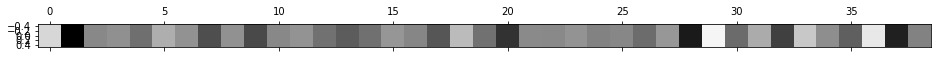

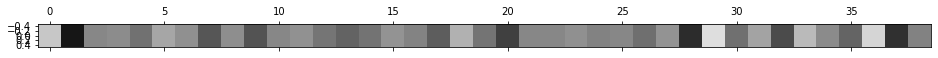

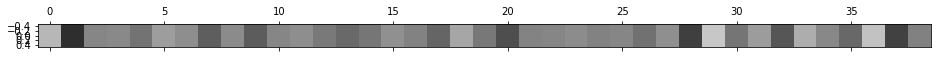

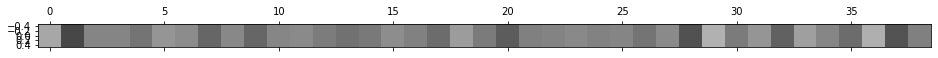

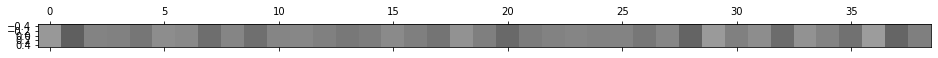

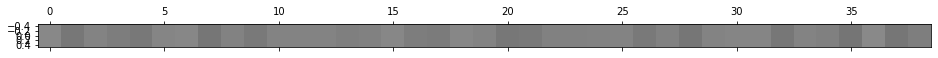

In [14]:
for l in lamb:    
    print (l)
    plt.matshow(net[0].mean(lambda_encode(l)).detach().cpu().numpy().reshape(1, -1), cmap='gray', norm = plt.Normalize(vmin=-2, vmax=2) )

In [7]:
net = var_net.VarNet(base_net.BaseLayer(784,  hidden_num, device),
                     base_net.BaseLayer(hidden_num, 10, device, act=lambda x:x)).to(device)

hnet = var_net.VarNet(base_net.BaseLayerLinear(784,  hidden_num),
                     base_net.BaseLayerLinear(hidden_num, 10, act=lambda x:x))
hnet = hnet.to(device)
net = net.to(device)
lam_results = {}
for lam in lamb:
    lam_results[lam] = []
    for s in range(start_num):        
        print (lam, s)
        hnet.load_state_dict(t.load(os.path.join(path_to_save, 'base_linear_start_{}.cpk'.format(s))))        
        utils.net_copy(hnet, net, lambda_encode(t.ones(1).to(device)[0]*lam), mode='base')
        lam_results[lam].append(utils.delete_10(net, device, lambda:utils.test_acc_net(net, device, test_loader), mode='base'))
lam_results = {float(k):lam_results[k] for k in lam_results}
import json
with open(os.path.join(path_to_save, 'results_base_linear.json'),'w') as out:
    out.write(json.dumps(lam_results))  

../src/base_net.py:14: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  t.nn.init.xavier_uniform(self.mean)


tensor(0.0010) 0
tensor(0.0010) 1
tensor(0.0010) 2
tensor(0.0010) 3
tensor(0.0010) 4
tensor(0.0100) 0
tensor(0.0100) 1
tensor(0.0100) 2
tensor(0.0100) 3
tensor(0.0100) 4
tensor(0.1000) 0
tensor(0.1000) 1
tensor(0.1000) 2
tensor(0.1000) 3
tensor(0.1000) 4
tensor(1) 0
tensor(1) 1
tensor(1) 2
tensor(1) 3
tensor(1) 4
tensor(10) 0
tensor(10) 1
tensor(10) 2
tensor(10) 3
tensor(10) 4
tensor(100.) 0
tensor(100.) 1
tensor(100.) 2
tensor(100.) 3
tensor(100.) 4


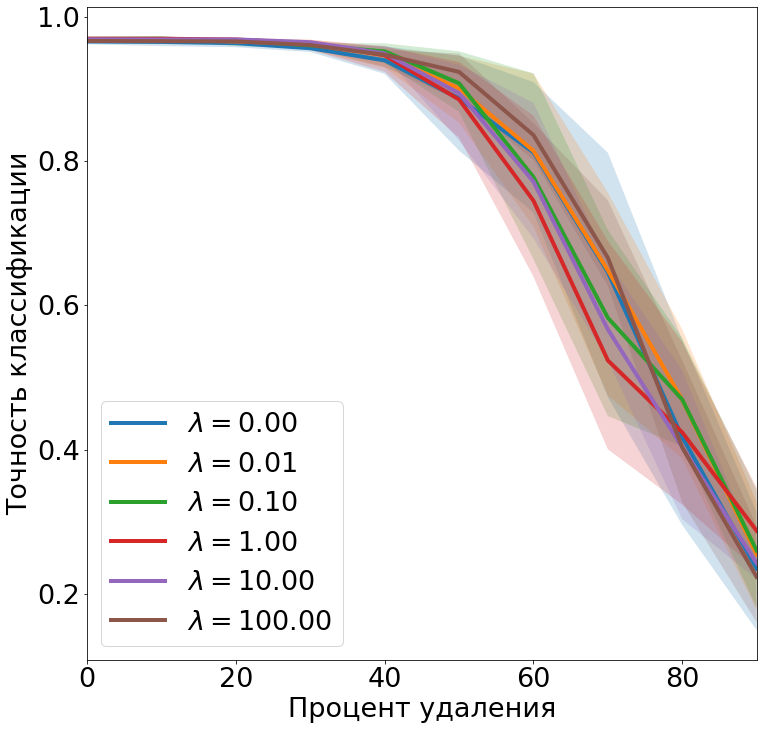

In [8]:
proc = [0,10,20,30,40,50,60,70,80,90]
plt.rcParams['figure.figsize'] = 12, 12
plt.rcParams.update({'font.size': 27})
plt.rc('lines', linewidth=4)
    
    
for lam in lamb:
    lam = float(lam)
    lam_str = "{:10.2f}".format(lam)

    plt.fill_between(proc, np.min(lam_results[lam], 0), np.max(lam_results[lam], 0), alpha=0.2)
    plt.plot(proc, np.mean(lam_results[lam], 0), label='$\lambda={}$'.format(lam_str))
plt.ylabel('Точность классификации', fontsize = 27)
plt.xlabel('Процент удаления', fontsize = 27)
plt.tick_params(axis='both', which='major', labelsize=27)
plt.legend(loc='lower left')
plt.autoscale(enable=True, axis='x', tight=True)
plt.savefig('Linear_base')
#plt.show()
